<a href="https://colab.research.google.com/github/TYH71/DELE_CA1/blob/main/Part%20B/4.1%20Modified_VGG16%20100%25%20Train%20Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 - Modified VGG16 with Full Train Data


- Name: Tan Yu Hoe
- Admin No: P2026309
- Class: DAAA/FT/2B/04

## Motivation

This notebook is purposed to train and evaluate a Convolution Neural Network on CIFAR-10 dataset, implementing a modified version of the VGG16 architecture. The network will be trained with 100% of the training data, and the test data will be used to evaluate the performance of the network.

## Personal Objectives

These are objectives / goals for myself to accomplish while attempting to perform image classification for the CIFAR-10 dataset.

1. Obtain a high test accuracy compared to public benchmark (The average benchmark for CIFAR-10 is about 85% Test Accuracy)
2. Experiment with multiple training strategies and CNN architectures

## !! Important Note !!

As this is an experimentation run, I would not go so in depth into Exploratory Data Analysis, Image Processing, and the Neural Network Archtecture itself. The markdown headers are used as checkpoints for me to better navigate around the notebook using Google Colaboratory.



In [1]:
# import relevant libraries/classes/dependencies
import os
import random

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
import datetime
!pip install -q pytz
import pytz
sg = pytz.timezone("Singapore")

# Set the random seeds - to ensure reproducibility
os.environ['TF_CUDNN_DETERMINISTIC'] = "1"
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

In [2]:
# Matplotlib Stylings
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.autolayout'] = True
plt.style.use('fivethirtyeight')

## Setting up **Weights and Biases**


In [3]:
# install and configure weights and biases
!pip install -q wandb
import wandb
from wandb.keras import WandbCallback
wandb.login()

wandb: Currently logged in as: tyh71 (use `wandb login --relogin` to force relogin)


True

## Training on a Tesla P100-PCIE-16GB


In [4]:
# Checking if GPU is available
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10212018011194963860
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16154099712
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14843356495853493744
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]


## Data Injestion


In [5]:
# Import numpy 
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = y_train.reshape(-1)
y_test  = y_test.reshape(-1)

# Lookup Table for Class Names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
print('Dataset Loaded')

Dataset Loaded


In [6]:
# Shape of Training and Testing Sets
print("X_train:", x_train.shape, "y_train:", y_train.shape)
print("X_test:", x_test.shape, "y_test:", y_test.shape)

X_train: (50000, 32, 32, 3) y_train: (50000,)
X_test: (10000, 32, 32, 3) y_test: (10000,)


In [7]:
# Import Keras Functions
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.utils import plot_model
from tensorflow.nn import local_response_normalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

## Feature Engineering


In [8]:
def preprocessing_func(x, y):
    # process X
    x = tf.cast(x, tf.float32) # convert to float32 first
    x = Rescaling(1./127.5, offset=-1)(x)
    
    return x, y

# transform 
x_train, y_train = preprocessing_func(x_train, y_train)
x_test, y_test = preprocessing_func(x_test, y_test)

# train_dataset.map

print("Training Shape:", x_train.shape, y_train.shape)
print("Testing Shape:", x_train.shape, y_test.shape) 

Training Shape: (50000, 32, 32, 3) (50000,)
Testing Shape: (50000, 32, 32, 3) (10000,)


## Data Augmentation


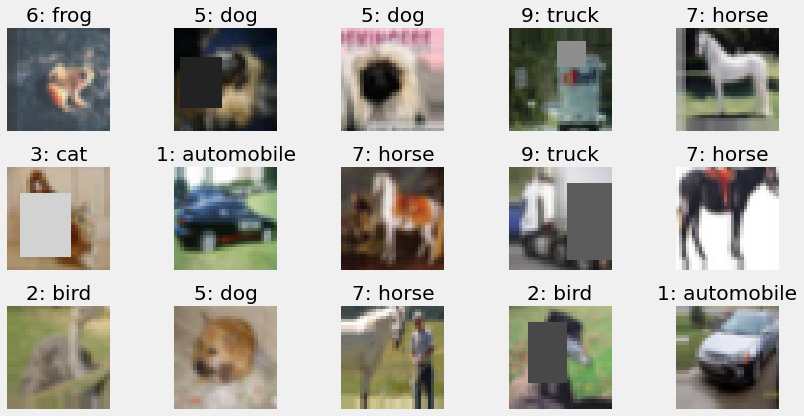

In [9]:
## source code: https://github.com/yu4u/mixup-generator/blob/master/random_eraser.py
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255):
    def eraser(input_img):
        img_h, img_w, _ = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        c = np.random.uniform(v_l, v_h)
        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

# prepare image data generator for augmentation
train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    preprocessing_function=get_random_eraser(v_l=-1, v_h=1),
    validation_split=0.,
)

# display images from
example_ds = train_datagen.flow(x=x_train, y=y_train)
fig = plt.figure()
for i in range(15):
    img, label = example_ds.next()
    ax = fig.add_subplot(3, 5, i+1)
    ax.imshow((img[0] + 1) / 2)
    ax.set_title(f"{label[0]}: {classes[label[0]]}")
    ax.axis('off')
plt.show()

## Modified VGG16 Architecture Implementation

The runner-up in the ILSVRC 2014 challenge was VGGNet, developed by Karen Simonyan and Andrew Zisserman from the Visual Geometry Group (VGG) research lab at Oxford University. It had a very simple and classical architecture, with 2 or 3 convolutional layers and a pooling layer, then again 2 or 3 convolutional layers and a pooling layer, and so on (reaching a total of just 16 or 19 covolutional layers, depending on the VGG variant, plus a final dense network with 2 hidden layers and the output layer. [1]

One important but minor concept in VGG16, it only uses the smallest receptive filter which is $3 \times 3$ filters (smallest size to capture the notion of left/right, up/down, center) as it is able to better extract key features from the convolution process as compared to $5 \times 5$ or $7 \times 7 $ filters.

In the section header I put in the word **Modified**, in later sections I will explain why and what was modified from the original VGG16 architecture.

| ![](https://i.imgur.com/BjTt4OZ.jpeg) | 
|:--:| 
| VGG16 Architecture |

---

- [1] Karen Simonyan and Andrew Zisserman, "Very Deep Covolutional Networks for Large Scale Image Recognition" arXiv preprint [arXiv:1409.1556](https://arxiv.org/abs/1409.1556) (2014)

### Modified VGG16 Convolution Block

Actually this block isn't special or unique to only VGG16, it is fairly common to have multiple convolution layers stack directly on top of one another before spatial pooling. (eg. AlexNet) Here, I created a slight modification, I added batch normalisation after each convolution layer, to have better training and adding some regualization effect on the network. Furthermore, I also added a 2D Spatial Dropout layer to add some regularization effect to the down-sampled feature map.

|![](https://i.imgur.com/8rUfe8d.jpeg)|
|:--:|
| Illustration of Modified VGG16 Convolution Block |


In [10]:
# VGG16 Block
def vgg16_module(neurons: int, conv_num:int, num:int, dropout=0):
    '''
    Creates a generic Hidden Conv2D Layer with ReLU Activations
    Including Batch Normalization and Max Pooling Layers
    
    Args:
        - neurons: number of neurons in the dense layer
        - conv_num: number of conv layer
        - num    : block number
        - dropout: amount of dropout regularization to be applied
    '''
    block = Sequential(name=f'Covolution_Block_{num}')

    for i in range(conv_num):
      block.add(Conv2D(neurons, kernel_size=(3, 3),
                  activation='relu', strides=1, padding='same', kernel_initializer='he_normal'))
      block.add(BatchNormalization())

    block.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding="same"))
    block.add(SpatialDropout2D(dropout, data_format='channels_last'))
    
    return block

### Building a VGG Network

Unlike the VGG16 architecture, I decided to include 4 convolution blocks instead of 5. This is done such that the convolution / feature extraction process in the network will only downsample to a $2 \times 2$ feature map. Afterwards, I plan to replace the entire classification block with `Global Max Pooling` to reduce the number of parameters, following the trend of mordern day CNN architectures.

- `Sparse Categorical Cross-Entropy`

As the prediction task is a multi-class image classification task, it is pretty straightforward Categorical Cross Entropy as the specified loss function, in order to predict the probabilities of each class. I used `Sparse Categorical Cross-Entropy` as the $Y$ labels came as an integer, thus there is no need to One-Hot encode the labels.

$$ J(w) = -\frac{1}{N} \sum^N_{i=1}{[y_{i}log(\hat{y}_i) + (1 - y_i)log(1 - \hat{y}_i)]} $$

- `Adaptive Momentum (Adam) Optimizer`

Generally, I would lean towards `Adam` optimizer over Stochastic Gradient Descent (SGD) as `Adam` has faster convergeance over `SGD` over a smaller amount of epochs.

```py
Adam(learning_rate=0.001)
```

- `Reduce Learning Rate on Plateau`

The intuition is using a big learning rate to quickly approach a local minima and reduce it once the validation loss hit a plateau (i.e. this learning rate is too big for now, we need smaller value to be able to fine tune the parameters more). The term plateau refers to the point when the change in loss w.r.t. training iterations is less than a pre-determined threshold $\epsilon$.

|![](https://imgur.com/Y6xQEY3.png)|
|:--:|
|Illustration of Learning Rate Optimization over a Plateau|


- `Global Average Pooling`

In the traditional VGG16 architecture, there are usually fully connected layers at the top of the network sequence for classification in a CNN. This gives of a problem of having too many parameters, increasing training time and model complexity.

I decided to follow the typical approach by modern  architecture, replacing these fully connected layers with Global Average Pooling, which directly output the spatial average of the feature maps from the previous convolution layer. The resulting vector is then output into the softmax output layer. Global Average Pooling creates an output that has better meaning and interpretation as it enforces correspondance between feature maps and categories. [2]

---

- [2] M. Lin, Q. Chen, en S. Yan, “Network In Network”, arXiv [cs.NE]. 2014.


In [11]:
def vgg16_builder(input_shape=(32, 32, 3)):
    model = Sequential(name='Custom_VGG16')
    
    # Input and Feature Engineering
    model.add(Input(input_shape, name='Input_Layer'))

    # Convolutional Block - Feature Extraction
    model.add(vgg16_module(64, 2, 0, 0))
    model.add(vgg16_module(128, 2, 1, 0))
    model.add(vgg16_module(256, 3, 2, 0))
    model.add(vgg16_module(512, 3, 3, 0))

    # Global Average Pooling - Global average pooling operation for spatial data
    model.add(GlobalAveragePooling2D(data_format='channels_last'))

    # Output Layer - Softmax Activation
    model.add(Dense(10, activation='softmax', name='Softmax_Output_Layer'))
    
    return model

In [12]:
# Initialise Weights and Biases run
current_time = datetime.datetime.now(sg).strftime("%d:%m:%Y_%H:%M")
run = wandb.init(
    project="CIFAR-10 ConvNet",
    name=f"Modified VGG16 w/ 100% training data {[current_time]}",
    config={
        "learning_rate": 0.001,
        "epochs": 100,
        "batch_size": 512,
        "loss_function": "sparse_categorical_crossentropy",
        "architecture": "Modified VGG16",
        "dataset": "CIFAR-10"
    },
    group="Modified VGG16 w/ 100% train data"
)

# Prepare Configurations
config = wandb.config

# Build the Network
tf.keras.backend.clear_session() # Resets all state generated by Keras
vgg = vgg16_builder()
vgg.summary()

# Preparing Optimizer
optimizer = Adam(learning_rate=config.learning_rate)

# Compiling - Adam Optimizer Categorical Cross Entropy Loss Function
vgg.compile(
    optimizer=optimizer, 
    loss=config.loss_function, 
    metrics=['accuracy']
)

Model: "Custom_VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Covolution_Block_0 (Sequent  (None, 16, 16, 64)       39232     
 ial)                                                            
                                                                 
 Covolution_Block_1 (Sequent  (None, 8, 8, 128)        222464    
 ial)                                                            
                                                                 
 Covolution_Block_2 (Sequent  (None, 4, 4, 256)        1478400   
 ial)                                                            
                                                                 
 Covolution_Block_3 (Sequent  (None, 2, 2, 512)        5905920   
 ial)                                                            
                                                                 
 global_average_pooling2d (G  (None, 512)             

In [13]:
# Final Set of callback functions
callbacks = [
    WandbCallback(save_model=True),
    ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6, verbose=1),
]

In [14]:
%%time
# Train Model
baseline_hist = vgg.fit(
    x=train_datagen.flow(x_train, y_train, batch_size=config.batch_size),
    validation_data=tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(config.batch_size).prefetch(tf.data.AUTOTUNE),
    epochs=config.epochs,
    verbose=1,
    use_multiprocessing=True,
    workers=32,
    callbacks=callbacks
)
run.finish()

Epoch 1/100
98/98 [==============================] - 25s 183ms/step - loss: 1.6874 - accuracy: 0.4414 - val_loss: 1.7838 - val_accuracy: 0.3635 - lr: 0.0010
Epoch 2/100
98/98 [==============================] - 20s 168ms/step - loss: 1.1043 - accuracy: 0.6040 - val_loss: 1.6668 - val_accuracy: 0.4758 - lr: 0.0010
Epoch 3/100
98/98 [==============================] - 19s 166ms/step - loss: 0.9195 - accuracy: 0.6749 - val_loss: 0.9182 - val_accuracy: 0.6898 - lr: 0.0010
Epoch 4/100
98/98 [==============================] - 19s 168ms/step - loss: 0.7966 - accuracy: 0.7177 - val_loss: 0.6848 - val_accuracy: 0.7641 - lr: 0.0010
Epoch 5/100
98/98 [==============================] - 19s 167ms/step - loss: 0.7116 - accuracy: 0.7490 - val_loss: 0.7398 - val_accuracy: 0.7514 - lr: 0.0010
Epoch 6/100
98/98 [==============================] - 19s 164ms/step - loss: 0.6389 - accuracy: 0.7761 - val_loss: 0.6529 - val_accuracy: 0.7751 - lr: 0.0010
Epoch 7/100
98/98 [==============================] - 19s 1

accuracy,▁▄▅▆▆▇▇▇████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▇▇▇▇█████████████████████████████████
val_loss,█▄▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.96438
best_epoch,25
best_val_loss,0.35768
epoch,99
loss,0.10318
val_accuracy,0.8986


CPU times: user 11min 36s, sys: 9min 17s, total: 20min 53s
Wall time: 32min 37s


In [15]:
# in case of model training being interrupted
run.finish()

## Model Evaluation


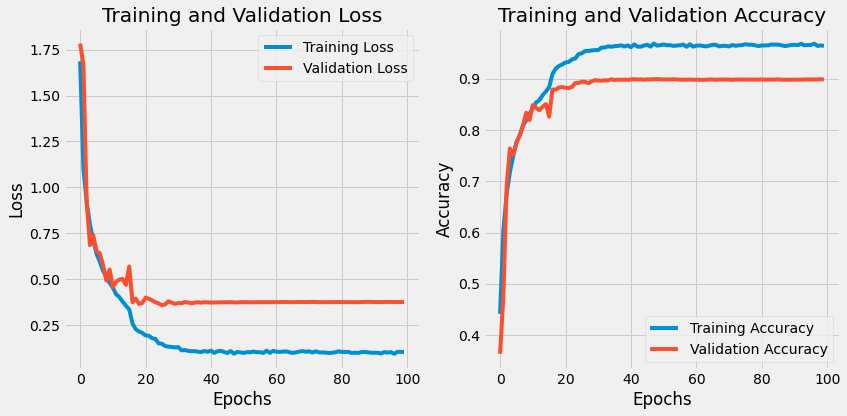

In [16]:
# Plot Learning Curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)

ax1.plot(baseline_hist.history['loss'], label='Training Loss')
ax1.plot(baseline_hist.history['val_loss'], label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
# ax1.set_ylim(bottom=0.0, top=1.0)
ax1.legend()

ax2.plot(baseline_hist.history['accuracy'], label='Training Accuracy')
ax2.plot(baseline_hist.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
# ax2.set_ylim(top=1.0, bottom=0.8)
ax2.legend()

plt.show()

In [17]:
# Evaluating Training and Testing Set
train = vgg.evaluate(x_train, y_train)
test  = vgg.evaluate(x_test, y_test)

# Creating a Logger to store all Evaluation Results
logger = pd.DataFrame(columns=['Train Loss', 'Train Acc', 'Test Loss', 'Test Acc'])
logger = logger.append(
    pd.Series(
        {
            'Train Loss': train[0],
            'Train Acc' : train[1],
            'Test Loss' : test[0],
            'Test Acc'  : test[1],
            'Test Percentage Error': "{:.2%}".format(1.0 - test[1])
        },
        name='Modified VGG16 w/ Image Augmentation',))
logger

313/313 [==============================] - 2s 6ms/step - loss: 0.3755 - accuracy: 0.8986


,Train Loss,Train Acc,Test Loss,Test Acc,Test Percentage Error
Modified VGG16 w/ Image Augmentation,0.023296,0.99358,0.375532,0.8986,10.14%


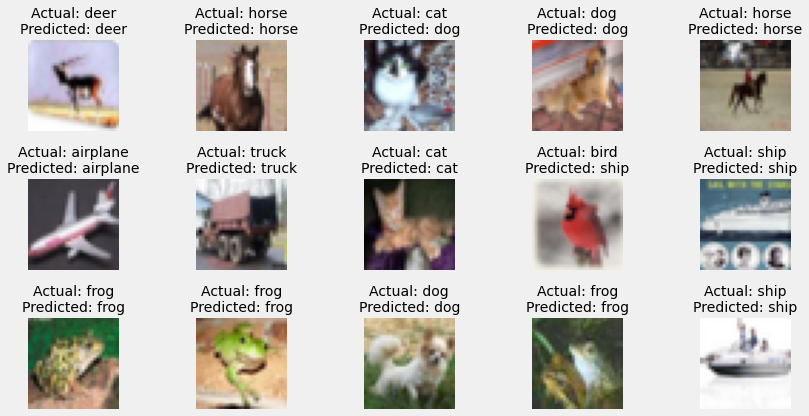

In [18]:
# Predict the values from the test dataset
y_pred = vgg.predict(x_test)
# Convert predictions classes to one hot encoded vectors 
y_pred_class = np.argmax(y_pred, axis = 1) 

w = 5
h = 3
fig = plt.figure(figsize=(12, 6), tight_layout=True)
for i in range(w*h):
  rand_idx = np.random.randint(0, len(x_test))
  ax = fig.add_subplot(h, w, i+1)
  ax.imshow((tf.reshape(x_test[rand_idx], (32, 32, 3))+1)/2)
  ax.axis('off')
  ax.set_title(f'Actual: {classes[y_test[rand_idx]]}\nPredicted: {classes[y_pred_class[rand_idx]]}', fontsize=14)
plt.show()

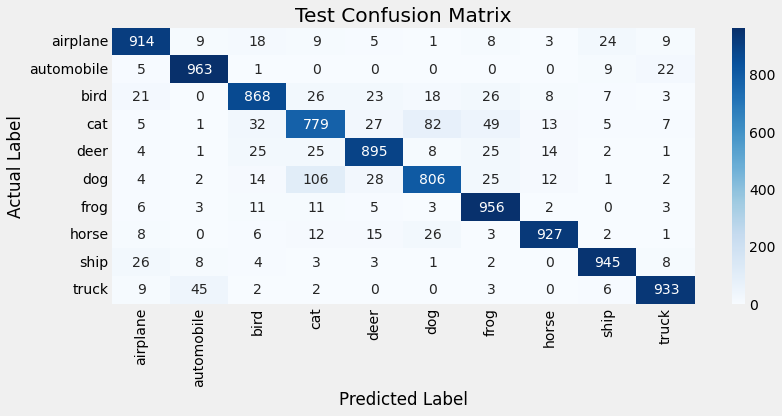

In [19]:
from sklearn.metrics import confusion_matrix
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_class)

sns.heatmap(confusion_mtx, cmap='Blues', annot=True, xticklabels=classes, yticklabels=classes, fmt='.3g')
plt.title('Test Confusion Matrix')
plt.xticks(rotation=90)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [20]:
from sklearn.metrics import classification_report
# print out classification report
print(classification_report(y_test, y_pred_class, target_names=classes))

              precision    recall  f1-score   support

    airplane       0.91      0.91      0.91      1000
  automobile       0.93      0.96      0.95      1000
        bird       0.88      0.87      0.88      1000
         cat       0.80      0.78      0.79      1000
        deer       0.89      0.90      0.89      1000
         dog       0.85      0.81      0.83      1000
        frog       0.87      0.96      0.91      1000
       horse       0.95      0.93      0.94      1000
        ship       0.94      0.94      0.94      1000
       truck       0.94      0.93      0.94      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



## Observations and Further Improvements

- The modified VGG architecture scored a very high testing accuracy for CIFAR-10.
- It seems that when feeding the entire dataset into the network, the test accuracy slightly decreases from the initial network.
- Despite having a high validation accuracy, the model is still overfitting greatly.
- Overall, I believed that I have achieved both personal objective of mine, but for further improvement, I would like to explore more `Data Augmentation` options to add more regularization effect to the network.


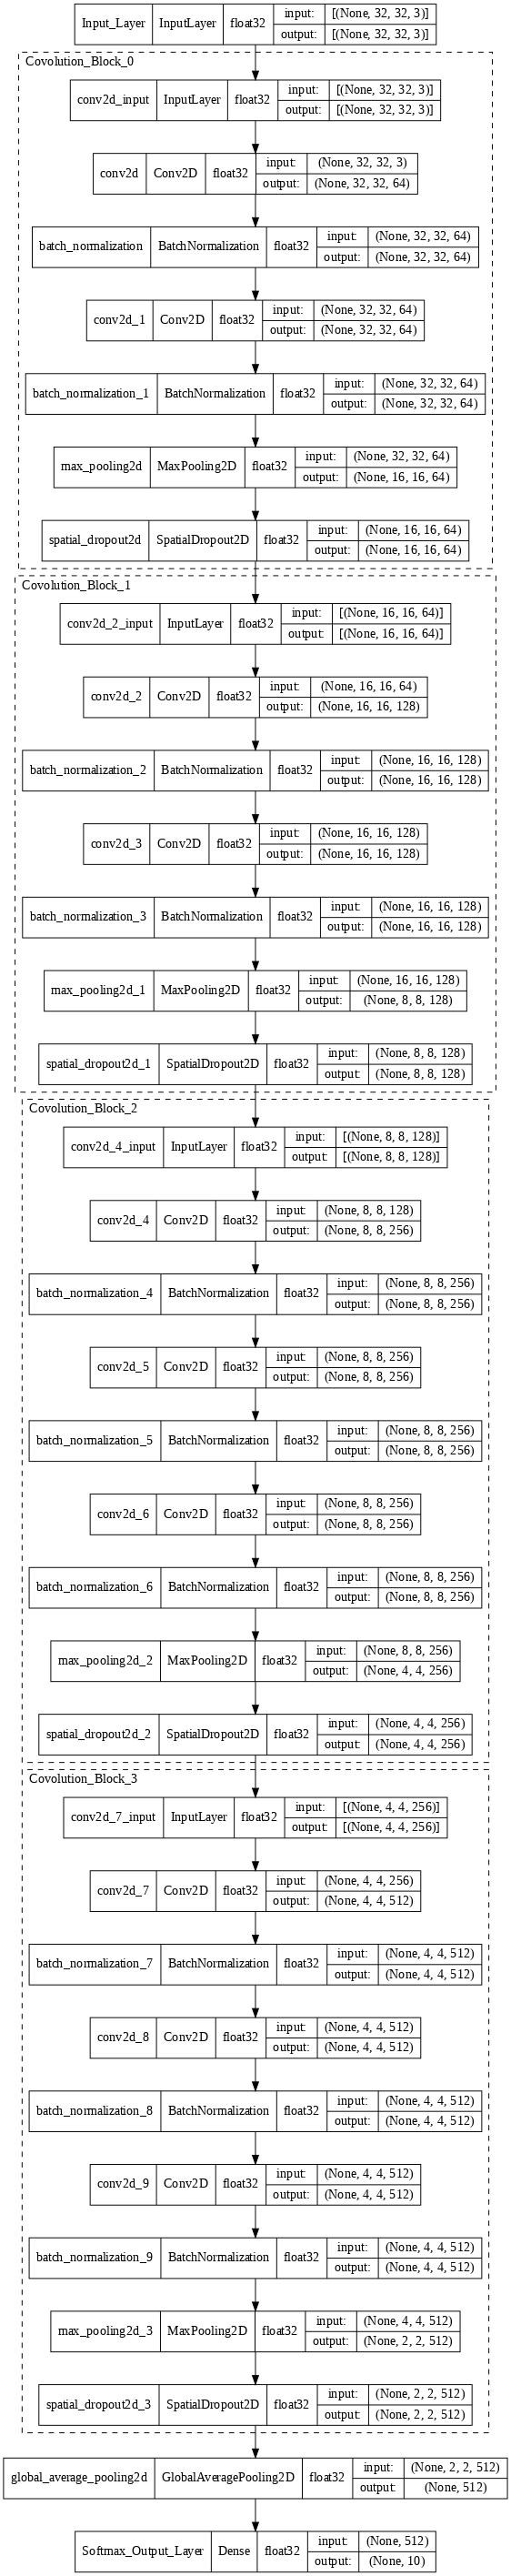

In [21]:
# Display Model Architecture in Notebook Output
from tensorflow.keras.utils import plot_model
plot_model(vgg, show_shapes=True, show_dtype=True,
    show_layer_names=True, expand_nested=True, dpi=70)